### Explorative Analyse der Smartmeter Daten

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

from data_loader import smartmeter_load
import seaborn as sns
import matplotlib as plt
import polars as pl

In [2]:
smart_meter = smartmeter_load(data_path ='../data/raw/households')
smart_meter.describe()

statistic,timestamp,timestamp_local,date,household_id,group_assignment,affects_timepoint,kwh_received_total,kwh_received_heatpump,kwh_received_other,kwh_returned_total
str,str,str,str,str,str,str,f64,f64,f64,f64
"""count""","""936026""","""936026""","""936026""","""936026""","""936026""","""936026""",916807.0,35694.0,29075.0,230402.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",19219.0,900332.0,906951.0,705624.0
"""mean""","""2022-04-12 11:46:29.668635+00:…","""2022-04-12 13:46:29.668635+02:…","""2022-04-12 11:46:30.668635""",null,null,null,27.785552,21.378717,20.821304,17.992046
"""std""",null,null,null,null,null,null,23.272086,29.524287,20.726929,21.587601
"""min""","""2018-11-02 23:59:59+00:00""","""2018-11-03 00:59:59+01:00""","""2018-11-03""","""100101""","""control""","""after visit""",0.01,0.01,0.3,0.01
"""25%""","""2021-03-17 23:59:59+00:00""","""2021-03-18 00:59:59+01:00""","""2021-03-18""",null,null,null,12.6,5.56,9.3,1.27
"""50%""","""2022-08-30 23:59:59+00:00""","""2022-08-31 01:59:59+02:00""","""2022-08-31""",null,null,null,22.48,13.85,14.95,10.18
"""75%""","""2023-06-18 23:59:59+00:00""","""2023-06-19 01:59:59+02:00""","""2023-06-19""",null,null,null,37.09,28.08,23.63,27.7
"""max""","""2024-03-20 23:59:59+00:00""","""2024-03-21 00:59:59+01:00""","""2024-03-21""","""998181""","""treatment""","""unknown""",4689.98,401.96,171.97,223.36


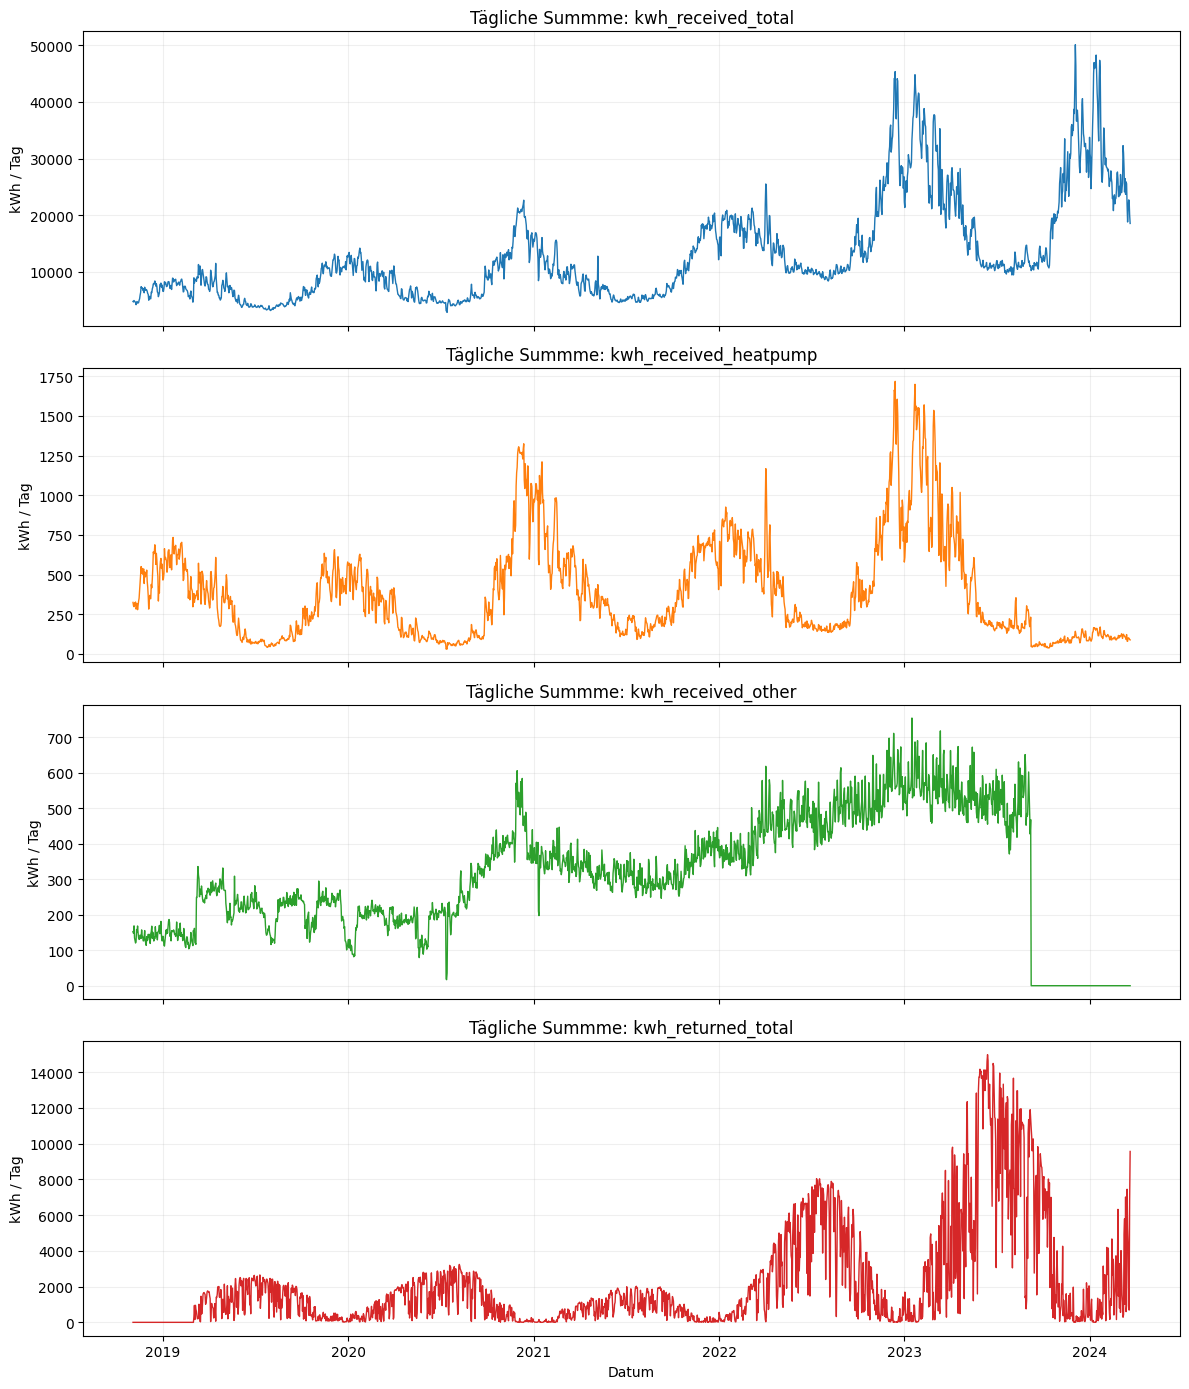

In [3]:

smart_meter = smart_meter.with_columns(
    pl.col("timestamp_local").dt.date().alias("date")
)

smart_meter_sum = (smart_meter.group_by('date').agg([
                                                        pl.col("kwh_received_total").sum(),
                                                        pl.col("kwh_received_heatpump").sum(),
                                                        pl.col("kwh_received_other").sum(),
                                                        pl.col("kwh_returned_total").sum()
                                                        ]).sort("date"))

import matplotlib.pyplot as plt

metrics = ["kwh_received_total", "kwh_received_heatpump", "kwh_received_other", "kwh_returned_total"]
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 14), sharex=True)

for i, col in enumerate(metrics):
    # Polars Series direkt plotten
    axes[i].plot(
        smart_meter_sum["date"], 
        smart_meter_sum[col], 
        color=f"C{i}",
        linewidth=1
    )
    axes[i].set_title(f"Tägliche Summme: {col}", fontsize=12)
    axes[i].set_ylabel("kWh / Tag")
    axes[i].grid(True, alpha=0.2)

plt.xlabel("Datum")
plt.tight_layout()
plt.show()

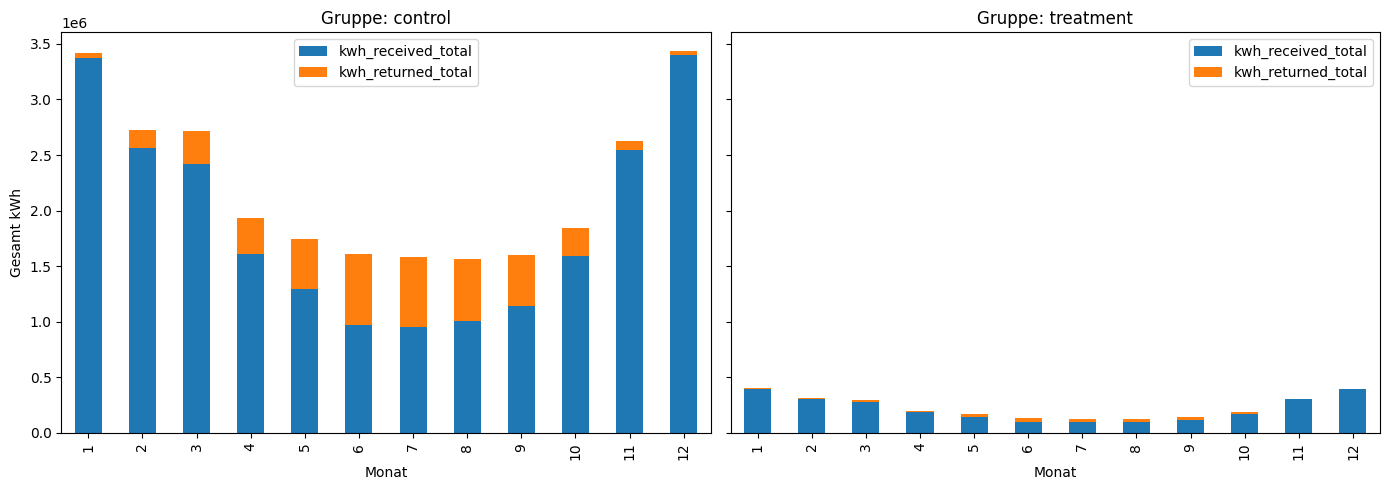

In [4]:
import matplotlib.pyplot as plt

# Wir berechnen die Summen pro Gruppe und Monat für einen besseren Überblick
# Falls du 'date' noch nicht hast, vorher: .with_columns(pl.col("timestamp").dt.date().alias("date"))
plot_df = (
    smart_meter
    .with_columns(pl.col("date").dt.month().alias("month"))
    .group_by(["group_assignment", "month"])
    .agg([
        pl.col("kwh_received_total").sum(),
        pl.col("kwh_returned_total").sum()
    ])
    .sort("month")
)

# Plotten
groups = plot_df["group_assignment"].unique().to_list()
fig, axes = plt.subplots(1, len(groups), figsize=(14, 5), sharey=True)

for i, group in enumerate(groups):
    # Filter für die aktuelle Gruppe und Umwandlung zu Pandas nur für den Plot
    group_data = plot_df.filter(pl.col("group_assignment") == group).to_pandas()
    
    # Bar-Plot: Received vs Returned
    group_data.set_index("month")[["kwh_received_total", "kwh_returned_total"]].plot(
        kind="bar", 
        stacked=True, 
        ax=axes[i],
        color=["#1f77b4", "#ff7f0e"] # Blau für Bezug, Orange für Rückspeisung
    )
    
    axes[i].set_title(f"Gruppe: {group}")
    axes[i].set_xlabel("Monat")
    axes[i].set_ylabel("Gesamt kWh")

plt.tight_layout()
plt.show()

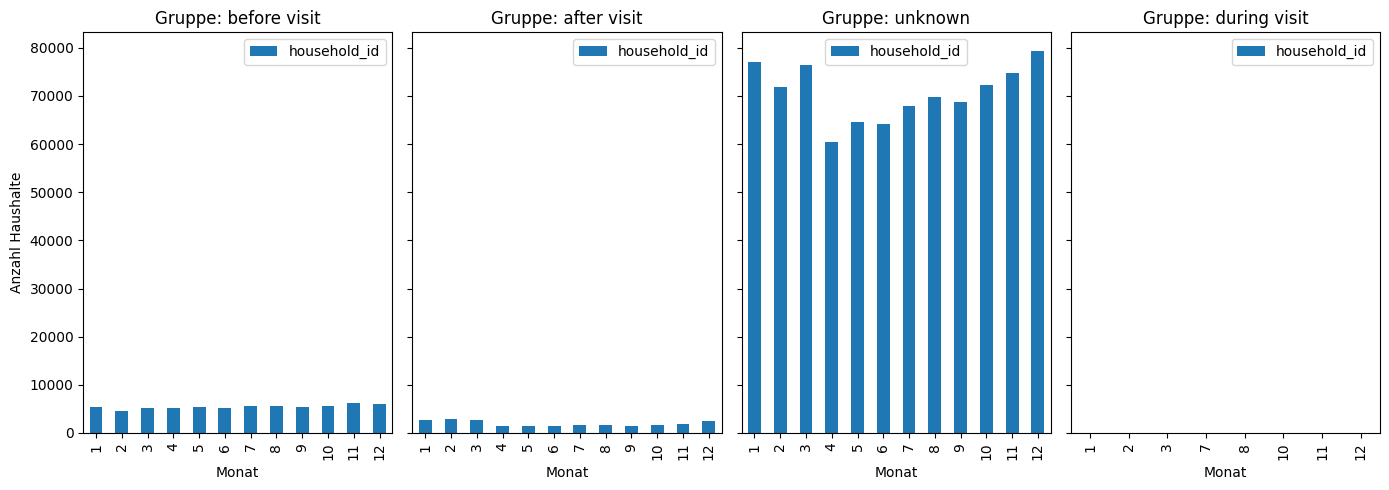

In [5]:
import matplotlib.pyplot as plt

# Wir berechnen die Summen pro Gruppe und Monat für einen besseren Überblick
# Falls du 'date' noch nicht hast, vorher: .with_columns(pl.col("timestamp").dt.date().alias("date"))
plot_df = (
    smart_meter
    .with_columns(pl.col("date").dt.month().alias("month"))
    .group_by(["affects_timepoint", "month"])
    .agg([
        pl.col("household_id").count(),
    ])
    .sort("month")
)

# Plotten
groups = plot_df["affects_timepoint"].unique().to_list()
fig, axes = plt.subplots(1, len(groups), figsize=(14, 5), sharey=True)

for i, group in enumerate(groups):
    # Filter für die aktuelle Gruppe und Umwandlung zu Pandas nur für den Plot
    group_data = plot_df.filter(pl.col("affects_timepoint") == group).to_pandas()
    
    # Bar-Plot: Received vs Returned
    group_data.set_index("month")[["household_id"]].plot(
        kind="bar", 
        stacked=True, 
        ax=axes[i],
        color=["#1f77b4", "#ff7f0e"] # Blau für Bezug, Orange für Rückspeisung
    )
    
    axes[i].set_title(f"Gruppe: {group}")
    axes[i].set_xlabel("Monat")
    axes[i].set_ylabel("Anzahl Haushalte")

plt.tight_layout()
plt.show()

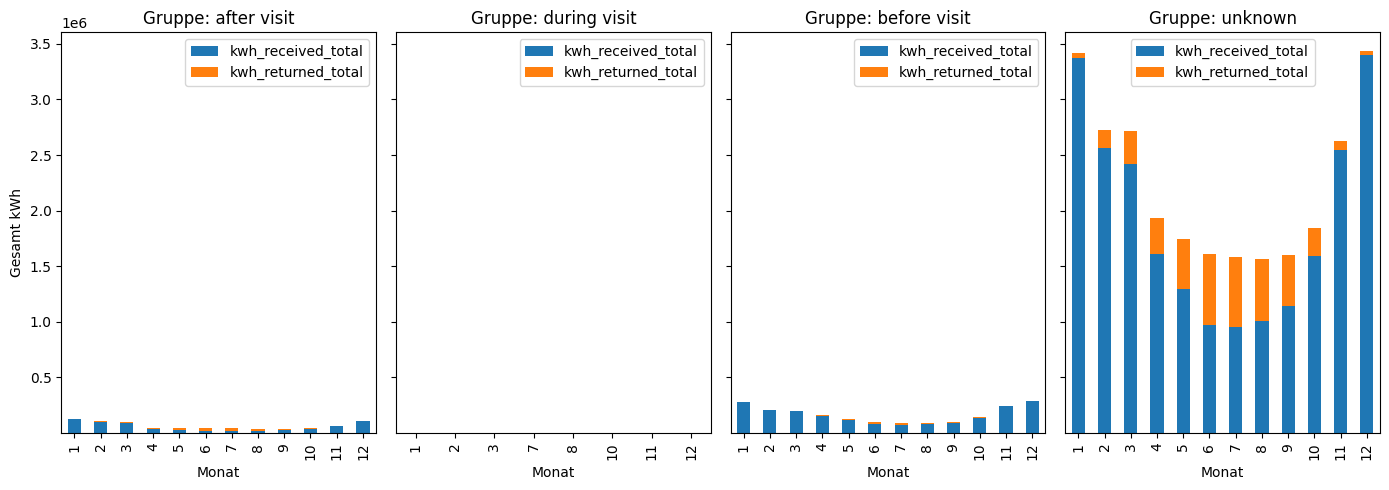

In [6]:
import matplotlib.pyplot as plt

# Wir berechnen die Summen pro Gruppe und Monat für einen besseren Überblick
# Falls du 'date' noch nicht hast, vorher: .with_columns(pl.col("timestamp").dt.date().alias("date"))
plot_df = (
    smart_meter
    .with_columns(pl.col("date").dt.month().alias("month"))
    .group_by(["affects_timepoint", "month"])
    .agg([
        pl.col("kwh_received_total").sum(),
        pl.col("kwh_returned_total").sum()
    ])
    .sort("month")
)

# Plotten
groups = plot_df["affects_timepoint"].unique().to_list()
fig, axes = plt.subplots(1, len(groups), figsize=(14, 5), sharey=True)

for i, group in enumerate(groups):
    # Filter für die aktuelle Gruppe und Umwandlung zu Pandas nur für den Plot
    group_data = plot_df.filter(pl.col("affects_timepoint") == group).to_pandas()
    
    # Bar-Plot: Received vs Returned
    group_data.set_index("month")[["kwh_received_total", "kwh_returned_total"]].plot(
        kind="bar", 
        stacked=True, 
        ax=axes[i],
        color=["#1f77b4", "#ff7f0e"] # Blau für Bezug, Orange für Rückspeisung
    )
    
    axes[i].set_title(f"Gruppe: {group}")
    axes[i].set_xlabel("Monat")
    axes[i].set_ylabel("Gesamt kWh")

plt.tight_layout()
plt.show()

## Explorative Analyse der Wetterdaten

In [7]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
from data_loader import  weather_load

weather_data = weather_load(data_path ='../data/raw/weather')
weather_data.describe()

statistic,date,weather_id,temperature_avg_daily,temperature_max_daily,temperature_min_daily,heatingdegree_sia_daily,heatingdegree_us_daily,coolingdegree_us_daily,humidity_avg_daily,precipitation_total_daily,sunshine_duration_daily,timestamp_local
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""1885""","""1885""",1885.0,1885.0,1885.0,1885.0,1885.0,1885.0,1885.0,1885.0,1885.0,"""1885"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""","""2021-07-31 00:00:00""",null,10.618568,15.594748,5.431406,8.460584,8.196499,0.515066,76.507586,2.662918,5.003289,"""2021-07-31 02:00:00+02:00"""
"""std""",null,null,7.273397,8.74089,6.455998,7.886636,6.517768,1.404647,12.188068,5.645564,4.689027,null
"""min""","""2019-01-01""","""8jB""",-8.3,-5.3,-14.8,0.0,0.0,0.0,42.6,0.0,0.0,"""2019-01-01 01:00:00+01:00"""
"""25%""","""2020-04-16""",null,4.8,8.7,0.0,0.0,1.4,0.0,68.0,0.0,0.4,"""2020-04-16 02:00:00+02:00"""
"""50%""","""2021-07-31""",null,10.4,15.2,5.3,9.6,7.9,0.0,77.9,0.0,3.9,"""2021-07-31 02:00:00+02:00"""
"""75%""","""2022-11-14""",null,16.9,22.7,10.9,15.2,13.5,0.0,86.3,2.8,8.9,"""2022-11-14 01:00:00+01:00"""
"""max""","""2024-02-28""","""8jB""",27.2,36.7,19.2,28.3,26.6,8.9,99.4,53.0,14.9,"""2024-02-28 01:00:00+01:00"""


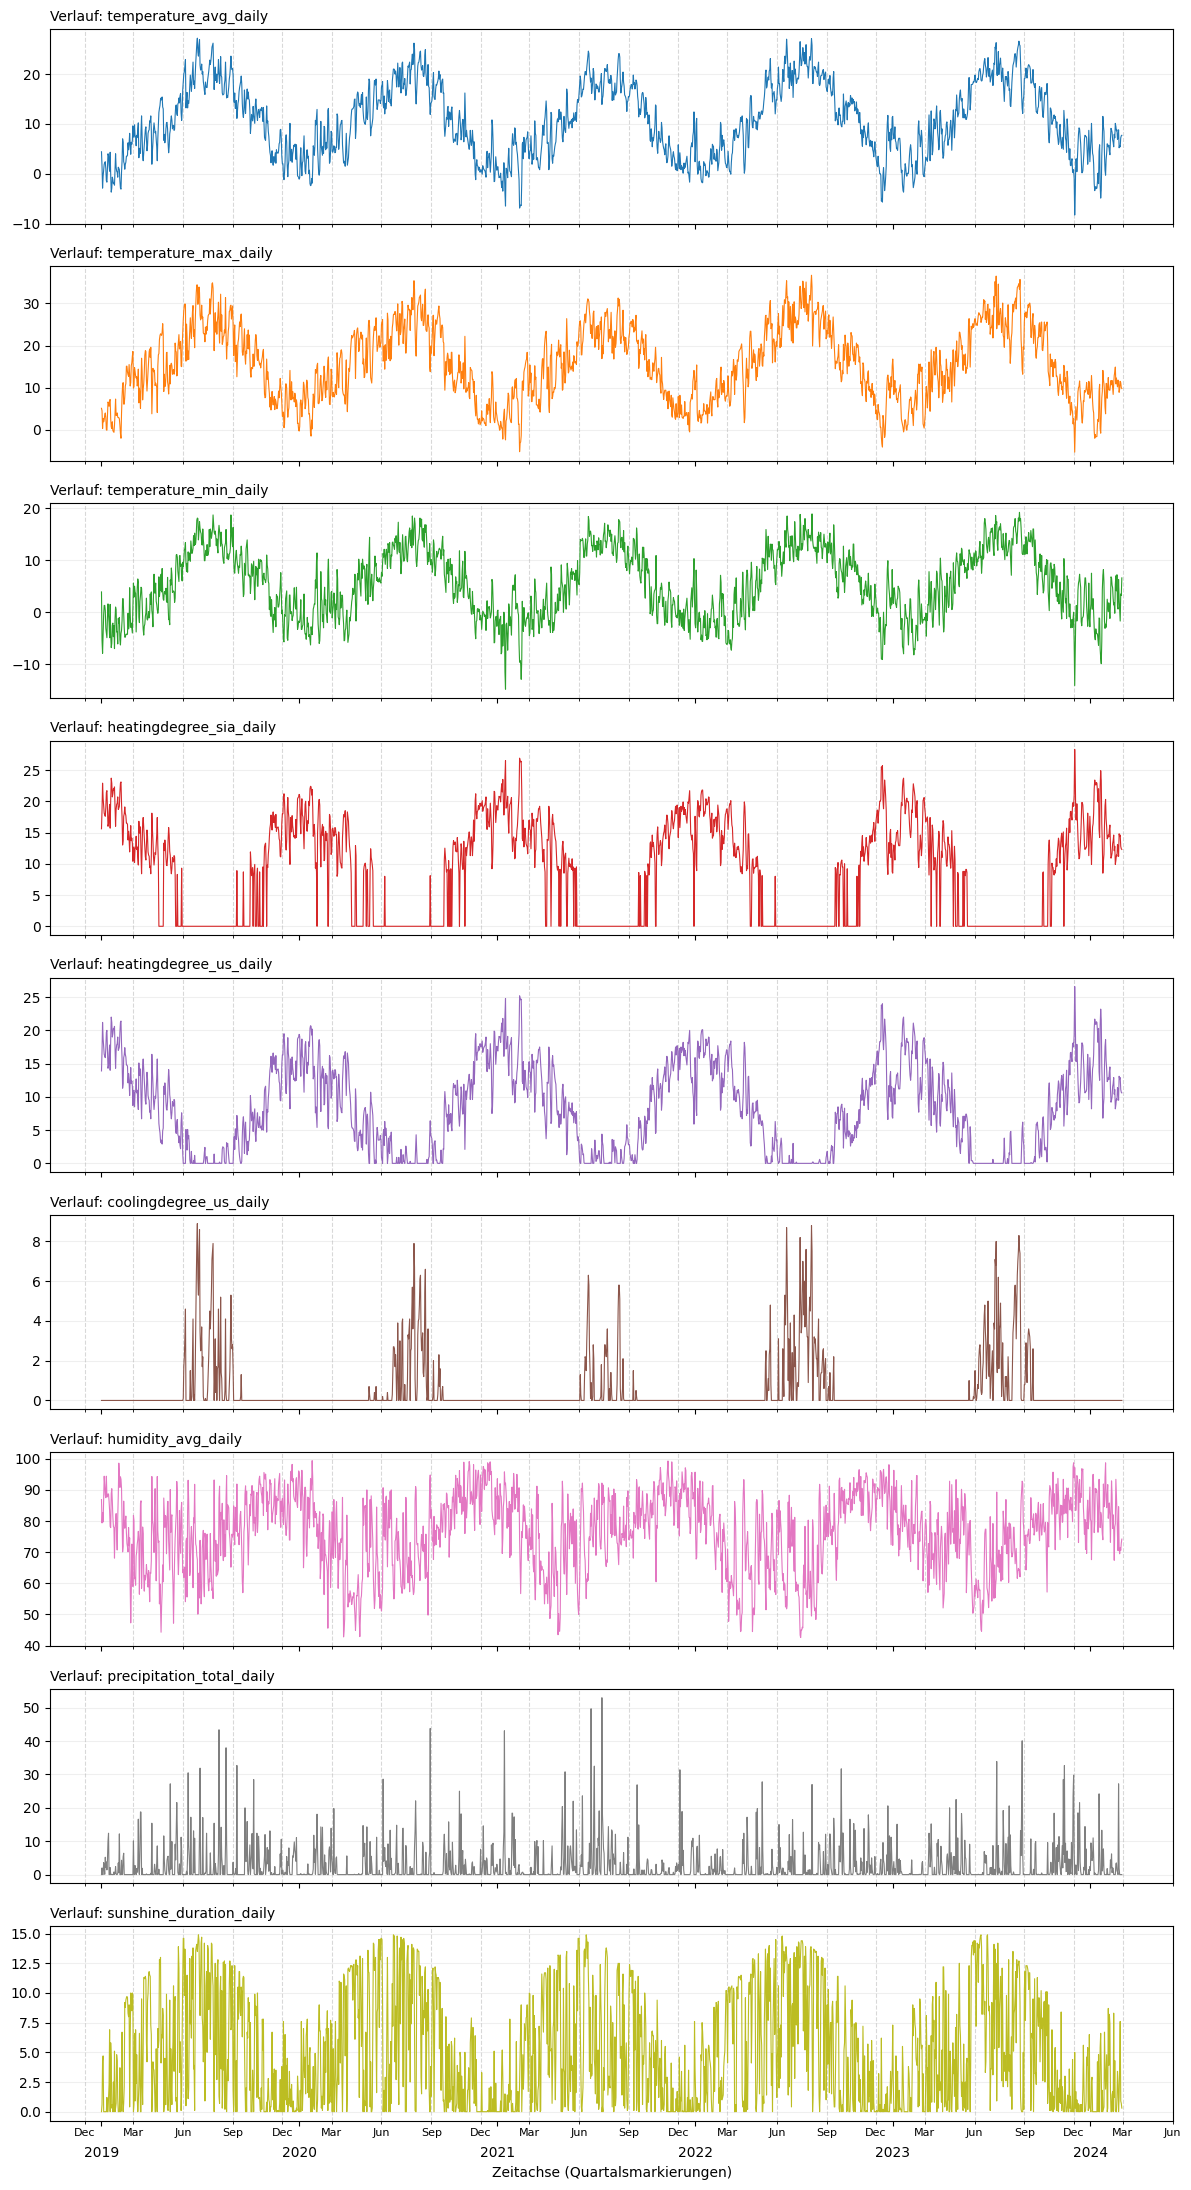

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import polars as pl

# Deine Metriken
metrics = [
    "temperature_avg_daily", "temperature_max_daily", "temperature_min_daily", 
    "heatingdegree_sia_daily", "heatingdegree_us_daily", "coolingdegree_us_daily",
    "humidity_avg_daily", "precipitation_total_daily", "sunshine_duration_daily"
]

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 22), sharex=True)

for i, col in enumerate(metrics):
    # 1. Daten plotten
    axes[i].plot(
        weather_data["date"], 
        weather_data[col], 
        color=f"C{i}",
        linewidth=0.8,
        label=col
    )

    # 2. X-Achse präzise einstellen
    # Große Marker für die Jahre
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('\n%Y')) # Jahr in neuer Zeile
    
    # Spezifische Monate: März(3), Juni(6), Sept(9), Dez(12)
    axes[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 6, 9, 12]))
    axes[i].xaxis.set_minor_formatter(mdates.DateFormatter('%b')) # %b = Monatskürzel (Mar, Jun, Sep...)

    # 3. Optik: Gitter für die Monate aktivieren
    axes[i].grid(True, which='minor', axis='x', color='gray', linestyle='--', alpha=0.3)
    axes[i].grid(True, which='major', axis='y', alpha=0.2)

    # Styling
    axes[i].set_title(f"Verlauf: {col}", fontsize=10, loc='left')
    axes[i].tick_params(axis='x', which='minor', labelsize=8, rotation=0)

plt.xlabel("Zeitachse (Quartalsmarkierungen)")
plt.tight_layout()
plt.show()

# Explorative Analyse der Technischen Haushaltsdaten

In [9]:
import sys
import os

# Wir gehen eine Ebene höher zum Projekt-Root und fügen 'src' hinzu
sys.path.append(os.path.abspath("../src"))

# Jetzt sollte der Import klappen
from data_loader import household_load

household_info = household_load(data_path ='../data/raw/households_info/')
household_info.describe()

statistic,household_id,group,weather_id,installation_haspvsystem,protocols_available,protocols_hasmultiplevisits,protocols_reportids,metadata_available,smartmeterdata_available_15min,smartmeterdata_available_daily,smartmeterdata_available_monthly
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64
"""count""",1408.0,"""1408""","""1408""",650.0,1408.0,1408.0,"""214""",1408.0,1408.0,1408.0,1408.0
"""null_count""",0.0,"""0""","""0""",758.0,0.0,0.0,"""1194""",0.0,0.0,0.0,0.0
"""mean""",2.1601e6,null,null,0.793846,0.151989,0.002131,null,0.964489,0.99929,0.921875,0.897727
"""std""",2.9614e6,null,null,null,null,null,null,null,null,null,null
"""min""",1060.0,"""control""","""8jB""",0.0,0.0,0.0,"""[137]""",0.0,0.0,0.0,0.0
"""25%""",412211.0,null,null,null,null,null,null,null,null,null,null
"""50%""",818882.0,null,null,null,null,null,null,null,null,null,null
"""75%""",1.189811e6,null,null,null,null,null,null,null,null,null,null
"""max""",9.981041e6,"""treatment""","""z6I""",1.0,1.0,1.0,"""[40]""",1.0,1.0,1.0,1.0


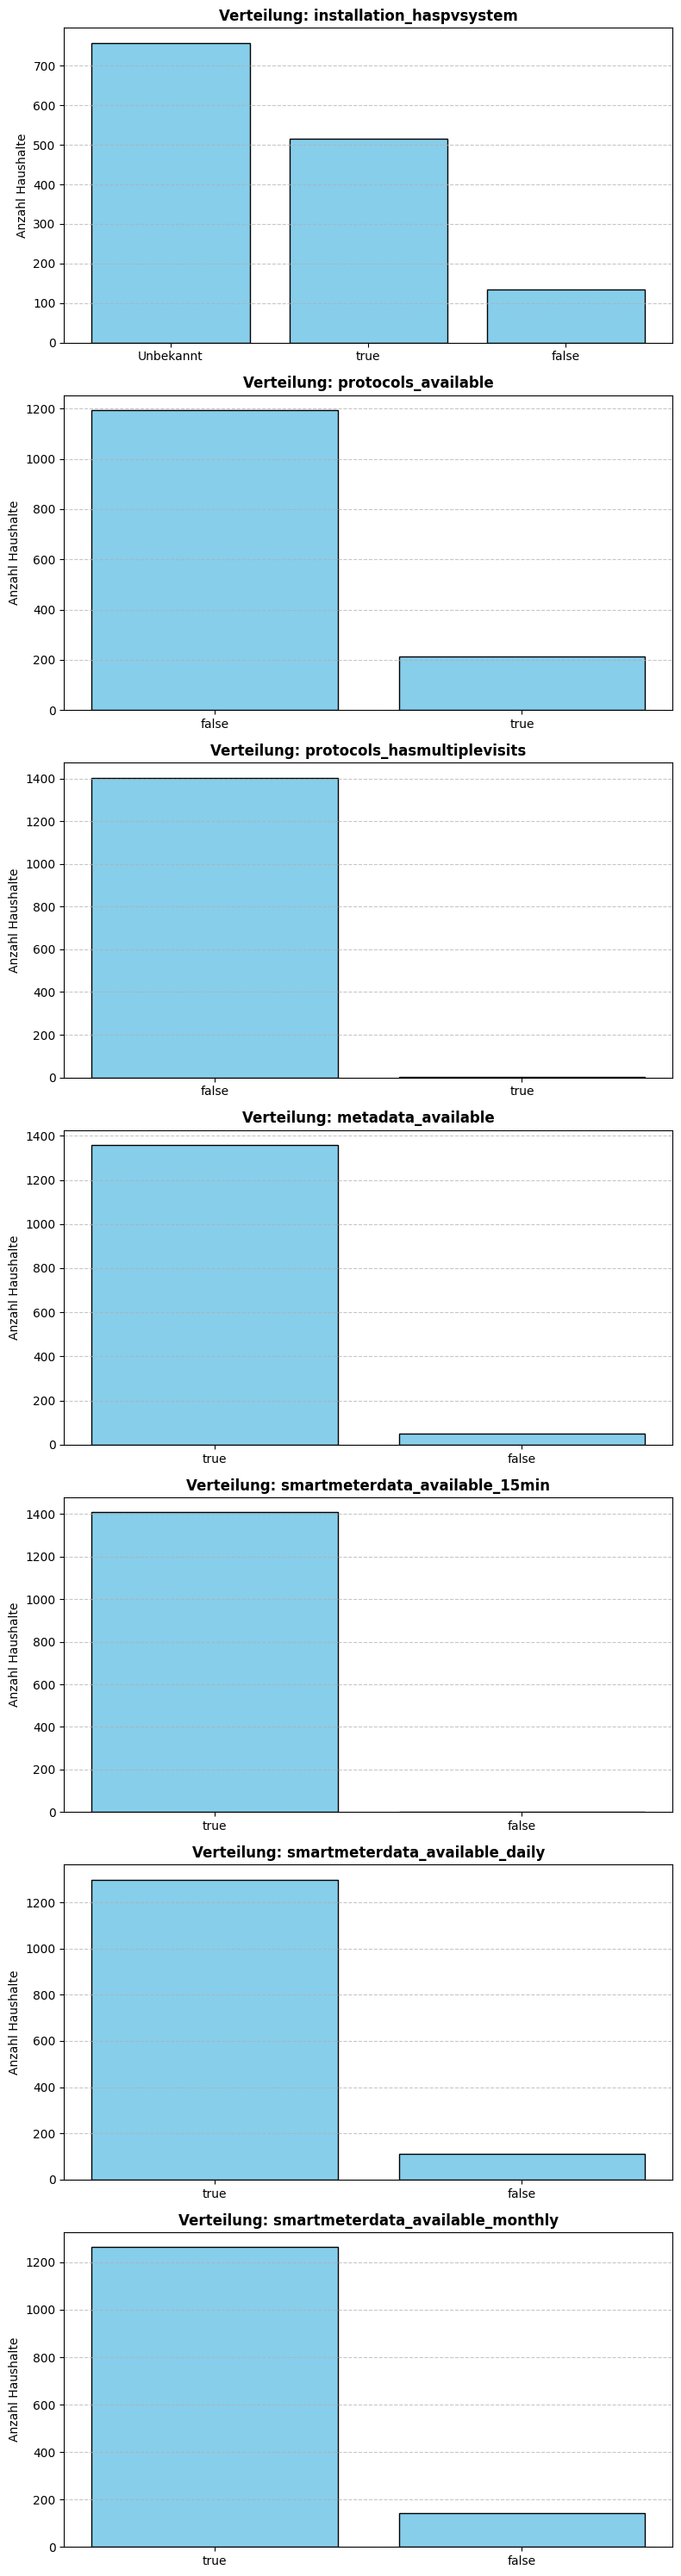

In [10]:
import polars as pl
import matplotlib.pyplot as plt

metrics = [
    "installation_haspvsystem", "protocols_available", "protocols_hasmultiplevisits", 
    "metadata_available", "smartmeterdata_available_15min", 
    "smartmeterdata_available_daily", "smartmeterdata_available_monthly"
]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 30))

for i, col in enumerate(metrics):
    # Wir greifen direkt auf die Spalte zu (Series), füllen nulls und zählen dann
    counts = (
        household_info[col]
        .fill_null("Unbekannt")
        .value_counts()
        .sort(by="count", descending=True)
    )
    
    # Da counts nun ein DataFrame mit der Spalte 'col' und 'count' ist:
    x_labels = counts[col].cast(pl.String).to_list()
    y_values = counts["count"].to_list()
    
    axes[i].bar(x_labels, y_values, color="skyblue", edgecolor="black")
    
    axes[i].set_title(f"Verteilung: {col}", fontsize=12, fontweight='bold')
    axes[i].set_ylabel("Anzahl Haushalte")
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Explorative Analyse der Meta Informationen zum Haushalt

In [11]:
import sys
import os

sys.path.append(os.path.abspath("../src"))

from data_loader import household_metainfo_load

household_info = household_metainfo_load(data_path ='../data/raw/protocols/')
household_info.describe()

statistic,report_id,household_id,visit_year,visit_date,building_type,building_housingunits,building_constructionyear,building_constructionyear_interval,building_renovated_windows,building_renovated_roof,building_renovated_walls,building_renovated_floor,building_floorareaheated_total,building_floorareaheated_basement,building_floorareaheated_groundfloor,building_floorareaheated_firstfloor,building_floorareaheated_secondfloor,building_floorareaheated_topfloor,building_floorareaheated_additionalareasplanned,building_floorareaheated_additionalareasplannedsize,building_residents,building_pvsystem_available,building_pvsystem_size,building_electricvehicle_available,heatpump_installation_type,heatpump_installation_year,heatpump_installation_manufacturer,heatpump_installation_model,heatpump_installation_heatingcapacity,heatpump_installation_refrigerant_type,heatpump_installation_refrigerant_content,heatpump_installation_normpoint,heatpump_installation_normpoint_cop,heatpump_installation_normpoint_electricpower,heatpump_installation_normpoint_heatingpower,heatpump_installation_location,…,heatpump_groundsource_brinecircuit_numberofholes,heatpump_groundsource_brinecircuit_coolingcapacity,heatpump_groundsource_brinecircuit_antifreezeexists,heatpump_groundsource_currentpressure,heatpump_groundsource_currentpressure_okay,heatpump_groundsource_currenttemperature,heatpump_groundsource_currenttemperature_okay,heatpump_heatingcurvesetting_toohigh_beforevisit,heatpump_heatingcurvesetting_changed,heatpump_heatingcurvesetting_outside20_beforevisit,heatpump_heatingcurvesetting_outside0_beforevisit,heatpump_heatingcurvesetting_outsideminus8_beforevisit,heatpump_heatingcurvesetting_outside20_aftervisit,heatpump_heatingcurvesetting_outside0_aftervisit,heatpump_heatingcurvesetting_outsideminus8_aftervisit,heatpump_heatinglimitsetting_toohigh_beforevisit,heatpump_heatinglimitsetting_changed,heatpump_heatinglimitsetting_beforevisit,heatpump_heatinglimitsetting_aftervisit,heatpump_nightsetbacksetting_activated_beforevisit,heatpump_nightsetbacksetting_activated_aftervisit,dhw_temperaturesetting_categorization,dhw_temperaturesetting_changed,dhw_temperaturesetting_beforevisit,dhw_temperaturesetting_aftervisit,dhw_storage_lastdescaling_toolongago,dhw_storage_lastdescaling_year,heatdistribution_expansiontank_pressure_categorization,heatdistribution_expansiontank_pressure_actual,heatdistribution_expansiontank_pressure_target,heatdistribution_expansiontank_systemheight,heatdistribution_circulation_pumpstageposition_changed,heatdistribution_circulation_pumpstageposition_beforevisit,heatdistribution_circulation_pumpstageposition_aftervisit,heatdistribution_recommendation_insulatepipes,heatdistribution_recommendation_installthermostaticvalve,heatdistribution_recommendation_installrpmvalve
str,f64,f64,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,str,f64,str,f64,str,f64,f64,str,str,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",410.0,217.0,"""410""","""0""","""409""",217.0,382.0,"""408""",410.0,410.0,410.0,410.0,408.0,140.0,366.0,320.0,48.0,63.0,180.0,16.0,410.0,204.0,25.0,37.0,"""410""",150.0,"""402""","""377""",391.0,"""410""",385.0,"""65""",71.0,85.0,"""71""","""285""",…,13.0,9.0,165.0,8.0,164.0,21.0,26.0,375.0,269.0,404.0,400.0,402.0,58.0,56.0,65.0,383.0,110.0,116.0,95.0,387.0,362.0,"""394""",281.0,396.0,32.0,410.0,255.0,"""403""",351.0,354.0,409.0,357.0,22.0,25.0,410.0,410.0,410.0
"""null_count""",0.0,193.0,"""0""","""410""","""1""",193.0,28.0,"""2""",0.0,0.0,0.0,0.0,2.0,270.0,44.0,90.0,362.0,347.0,230.0,394.0,0.0,206.0,385.0,373.0,"""0""",260.0,"""8""","""33""",19.0,"""0""",25.0,"""345""",339.0,325.0,"""339""","""125""",…,397.0,401.0,245.0,402.0,246.0,389.0,384.0,35.0,141.0,6.0,10.0,8.0,352.0,354.0,345.0,27.0,300.0,294.0,315.0,23.0,48.0,"""16""",129.0,14.0,378.0,0.0,155.0,"""7""",59.0,56.0,1.0,5

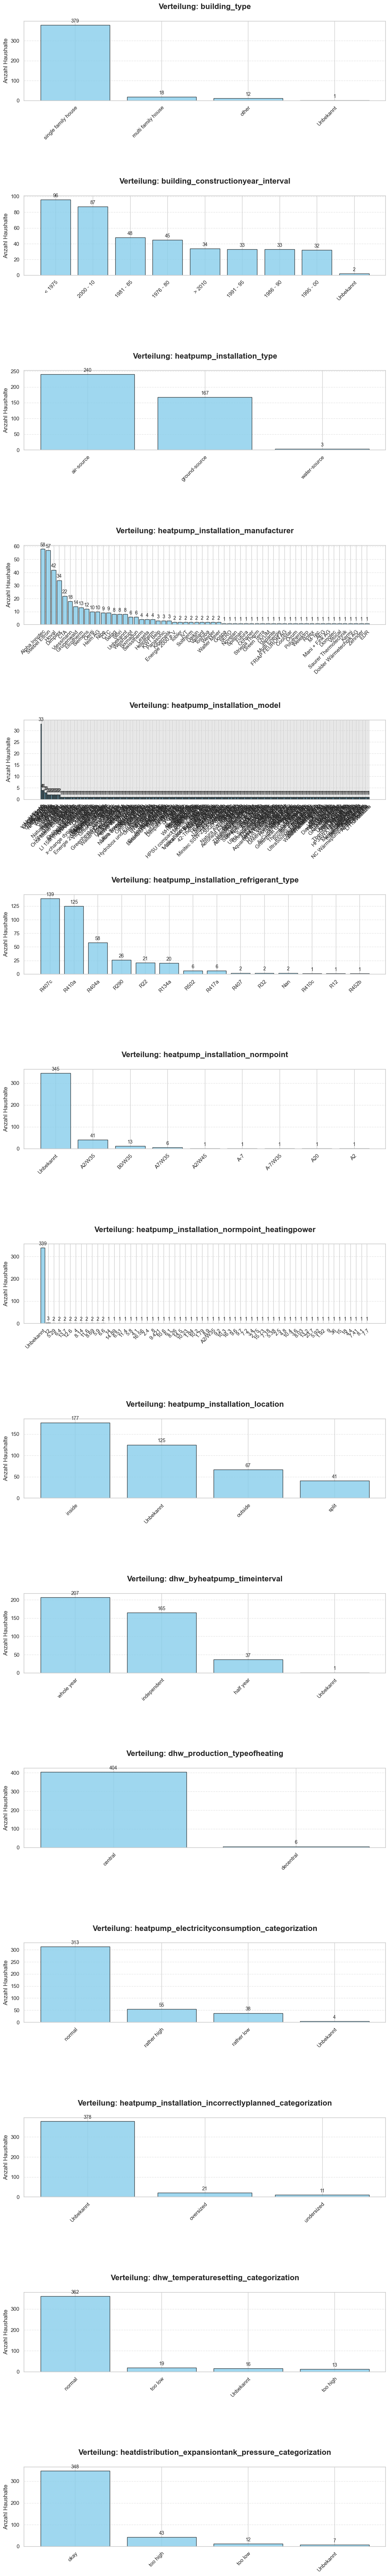

In [ ]:
import polars as pl
import matplotlib.pyplot as plt

# 1. Doppeltes Komma entfernt und Metriken definiert
metrics = [ 'building_type', 'building_constructionyear_interval', 'heatpump_installation_type', 'heatpump_installation_manufacturer', 'heatpump_installation_model', 'heatpump_installation_refrigerant_type', 'heatpump_installation_normpoint', 'heatpump_installation_normpoint_heatingpower', 'heatpump_installation_location', 'dhw_byheatpump_timeinterval', 'dhw_production_typeofheating', 'heatpump_electricityconsumption_categorization', 'heatpump_installation_incorrectlyplanned_categorization', 'dhw_temperaturesetting_categorization', 'heatdistribution_expansiontank_pressure_categorization'
]

# Erhöhte Breite und Höhe pro Subplot für bessere Lesbarkeit
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, len(metrics) * 5))

for i, col in enumerate(metrics):
    counts = (
        household_info[col]
        .fill_null("Unbekannt")
        .value_counts()
        .sort(by="count", descending=True)
    )
    
    x_labels = counts[col].cast(pl.String).to_list()
    y_values = counts["count"].to_list()
    
    bars = axes[i].bar(x_labels, y_values, color="skyblue", edgecolor="black", alpha=0.8)
    
    # --- TITEL ANPASSUNG ---
    # 'pad' schiebt den Titel nach oben, weg vom Plot
    axes[i].set_title(f"Verteilung: {col}", fontsize=16, fontweight='bold', pad=25)
    
    axes[i].set_ylabel("Anzahl Haushalte", fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)
    
    # --- X-ACHSE ANPASSUNG ---
    axes[i].set_xticks(range(len(x_labels)))
    # rotation_mode='anchor' sorgt für eine saubere Ausrichtung der gedrehten Texte
    axes[i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=11, rotation_mode='anchor')
    
    # Werte über den Balken anzeigen
    axes[i].bar_label(bars, padding=3, fontsize=10)

# 'hspace' steuert den vertikalen Abstand zwischen den Subplots
# 'top' lässt oben Platz für den ersten Titel
plt.subplots_adjust(hspace=0.8, top=0.95)

# Tight_layout mit zusätzlichem Padding
plt.tight_layout(pad=3.0)
plt.show()

In [19]:
import polars.selectors as cs
float_cols = household_info.select(cs.float()).columns

print(float_cols)

['building_housingunits', 'building_constructionyear', 'building_floorareaheated_total', 'building_floorareaheated_basement', 'building_floorareaheated_groundfloor', 'building_floorareaheated_firstfloor', 'building_floorareaheated_secondfloor', 'building_floorareaheated_topfloor', 'building_floorareaheated_additionalareasplannedsize', 'building_pvsystem_size', 'heatpump_installation_year', 'heatpump_installation_heatingcapacity', 'heatpump_installation_refrigerant_content', 'heatpump_installation_normpoint_cop', 'heatpump_installation_normpoint_electricpower', 'heatpump_installation_controllernotaccessible', 'heatpump_electricityconsumption_yearlyestimated', 'heatpump_groundsource_brinecircuit_length', 'heatpump_groundsource_brinecircuit_depth', 'heatpump_groundsource_brinecircuit_numberofholes', 'heatpump_groundsource_brinecircuit_coolingcapacity', 'heatpump_groundsource_currentpressure', 'heatpump_groundsource_currenttemperature', 'heatpump_heatingcurvesetting_outside20_beforevisit',

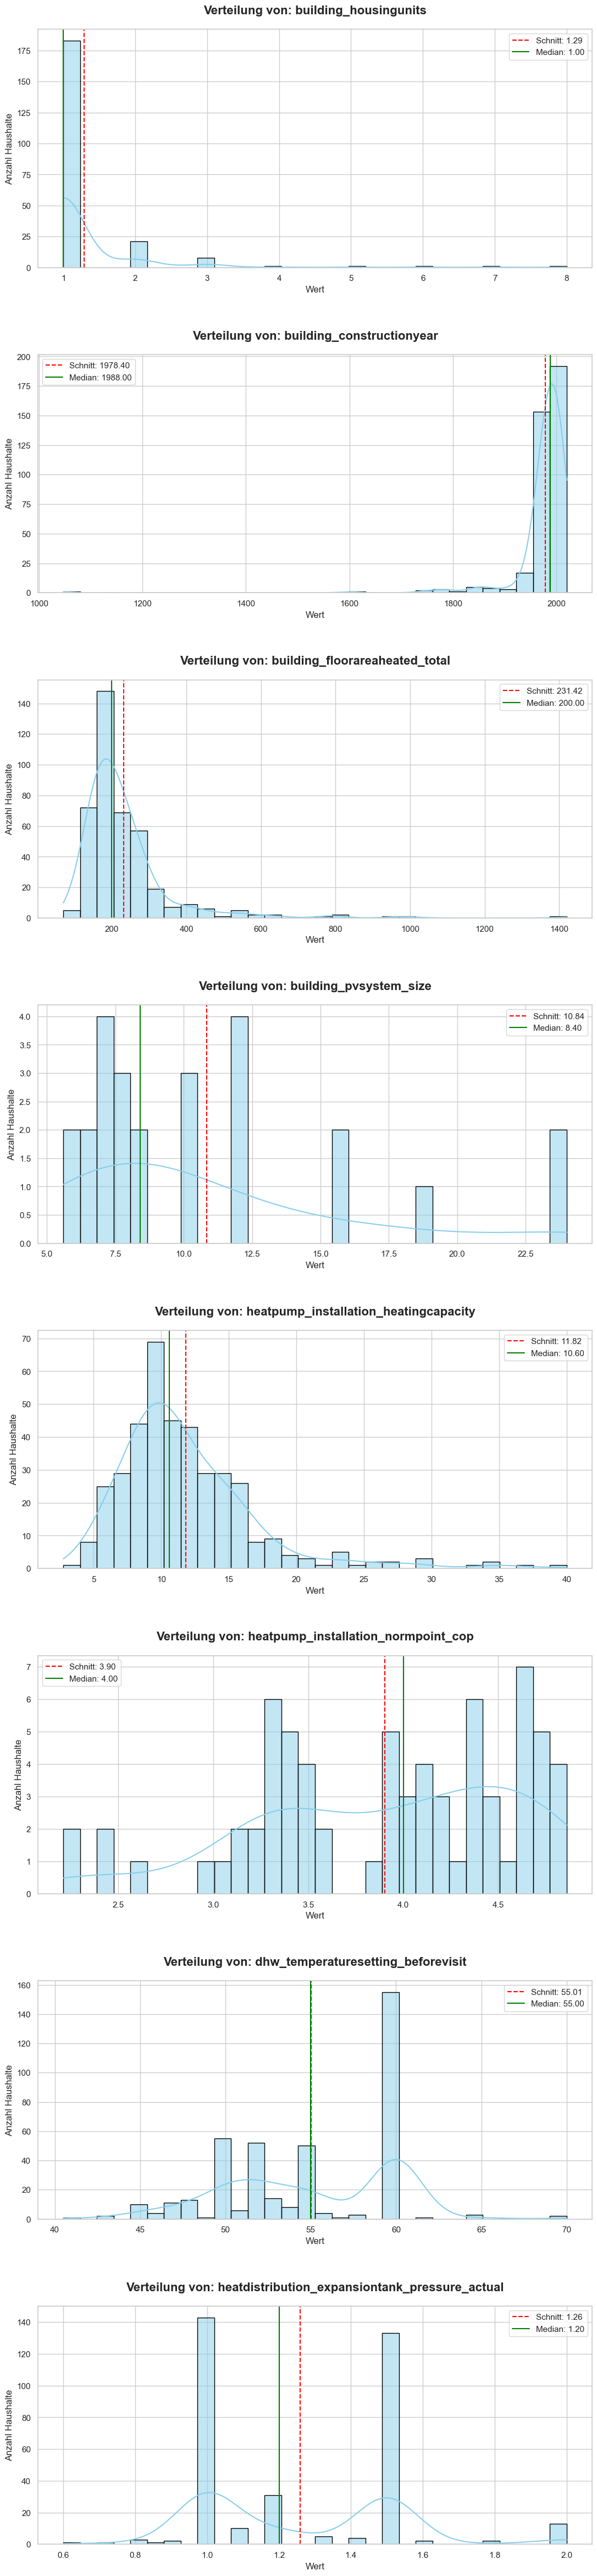

In [21]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Deine Liste (ich habe die unnötige Verschachtelung der Liste korrigiert)
metrics = [
    'building_housingunits', 'building_constructionyear', 'building_floorareaheated_total', 
    'building_pvsystem_size', 'heatpump_installation_heatingcapacity', 
    'heatpump_installation_normpoint_cop', 'dhw_temperaturesetting_beforevisit',
    'heatdistribution_expansiontank_pressure_actual'
] 
# Tipp: Ich habe hier nur eine Auswahl genommen, du kannst deine ganze Liste oben einfügen.

# Wir nutzen Seaborn für schönere statistische Plots
sns.set_theme(style="whitegrid")

# Dynamische Erstellung der Subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, len(metrics) * 6))

# Falls nur eine Metrik vorhanden ist, muss axes in eine Liste umgewandelt werden
if len(metrics) == 1:
    axes = [axes]

for i, col in enumerate(metrics):
    # Daten vorbereiten: Null-Werte entfernen, da Histogramme sonst Fehler werfen können
    data = household_info.select(col).drop_nulls().to_series()
    
    if data.len() == 0:
        axes[i].text(0.5, 0.5, f"Keine Daten für {col}", ha='center')
        continue

    # Histogramm mit Kerndichteschätzung (KDE) für die Verteilungskurve
    sns.histplot(data, bins=30, kde=True, ax=axes[i], color="skyblue", edgecolor="black")
    
    # --- TITEL & LABELS ---
    axes[i].set_title(f"Verteilung von: {col}", fontsize=16, fontweight='bold', pad=20)
    axes[i].set_xlabel("Wert", fontsize=12)
    axes[i].set_ylabel("Anzahl Haushalte", fontsize=12)
    
    # Statistische Kennzahlen als Linien einzeichnen (Mittelwert & Median)
    mean_val = data.mean()
    median_val = data.median()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Schnitt: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    axes[i].legend()

# Layout optimieren
plt.tight_layout(pad=4.0)
plt.show()

C:\Users\maxkr\AppData\Local\Temp\ipykernel_26296\1945439464.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df.to_pandas(), x="heatpump_installation_type", y="heatpump_installation_normpoint_cop",


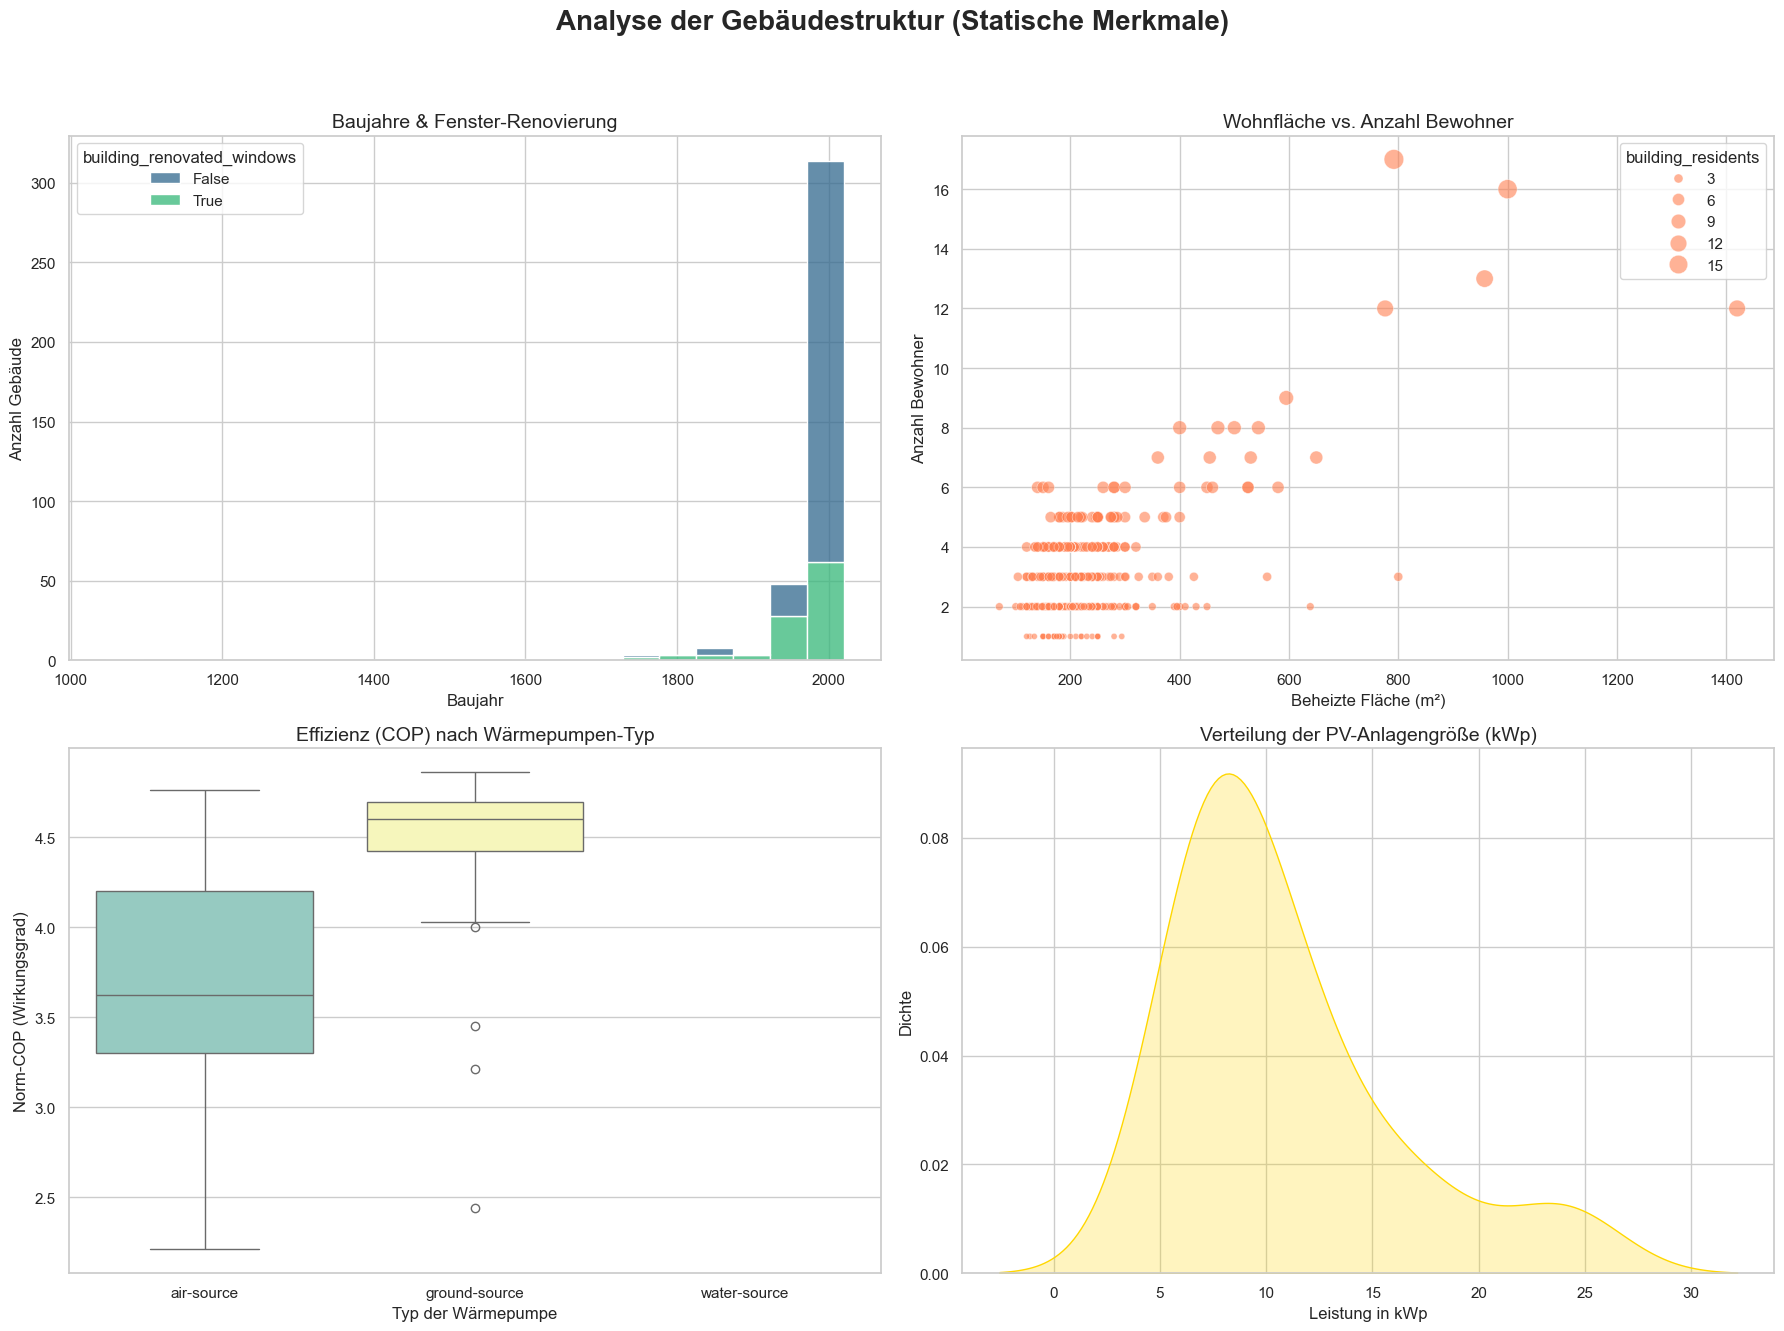

In [14]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_building_analysis(df: pl.DataFrame):
    # Styling
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle("Analyse der Gebäudestruktur (Statische Merkmale)", fontsize=20, fontweight='bold')

    # 1. Baujahr & Renovierungsstatus
    # Wir kombinieren das Baujahr mit der Info, ob Fenster renoviert wurden
    plt.subplot(2, 2, 1)
    sns.histplot(data=df.to_pandas(), x="building_constructionyear", hue="building_renovated_windows", 
                 multiple="stack", palette="viridis", bins=20)
    plt.title("Baujahre & Fenster-Renovierung", fontsize=14)
    plt.xlabel("Baujahr")
    plt.ylabel("Anzahl Gebäude")

    # 2. Beheizte Fläche vs. Anzahl Bewohner
    # Wichtig für den Warmwasserverbrauch (DHW)
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df.to_pandas(), x="building_floorareaheated_total", y="building_residents", 
                    alpha=0.6, size="building_residents", sizes=(20, 200), color="coral")
    plt.title("Wohnfläche vs. Anzahl Bewohner", fontsize=14)
    plt.xlabel("Beheizte Fläche (m²)")
    plt.ylabel("Anzahl Bewohner")

    # 3. Wärmepumpen-Technologie nach COP (Wirkungsgrad)
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df.to_pandas(), x="heatpump_installation_type", y="heatpump_installation_normpoint_cop", 
                palette="Set3")
    plt.title("Effizienz (COP) nach Wärmepumpen-Typ", fontsize=14)
    plt.xlabel("Typ der Wärmepumpe")
    plt.ylabel("Norm-COP (Wirkungsgrad)")

    # 4. PV-Größe Verteilung (für die Haushalte mit PV)
    plt.subplot(2, 2, 4)
    pv_data = df.filter(pl.col("building_pvsystem_size") > 0).to_pandas()
    sns.kdeplot(data=pv_data, x="building_pvsystem_size", fill=True, color="gold")
    plt.title("Verteilung der PV-Anlagengröße (kWp)", fontsize=14)
    plt.xlabel("Leistung in kWp")
    plt.ylabel("Dichte")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Aufruf mit deinem Metadaten-DataFrame
plot_building_analysis(household_info)

C:\Users\maxkr\AppData\Local\Temp\ipykernel_26296\1298940223.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


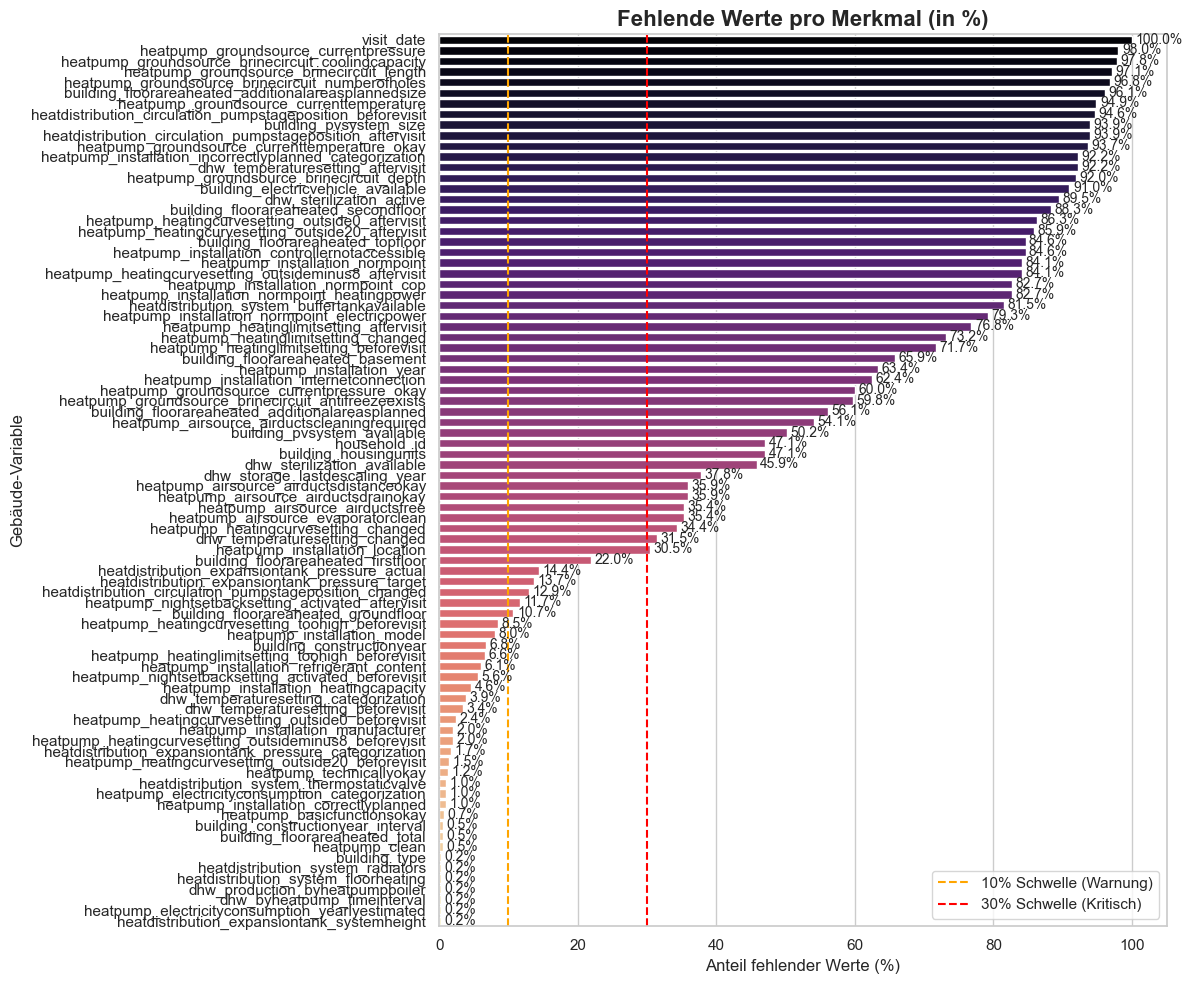

In [15]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values(df: pl.DataFrame):
    # 1. Prozentsatz der fehlenden Werte pro Spalte berechnen
    missing_data = df.select([
        (pl.col(c).null_count() / df.height * 100).alias(c)
        for c in df.columns
    ]).unpivot(variable_name="Spalte", value_name="Prozent_Fehlend")

    # 2. Nur Spalten mit fehlenden Werten anzeigen und sortieren
    missing_data = (
        missing_data
        .filter(pl.col("Prozent_Fehlend") > 0)
        .sort("Prozent_Fehlend", descending=True)
    )

    if missing_data.is_empty():
        print("✅ Hervorragend! Keine fehlenden Werte in diesem Datensatz gefunden.")
        return

    # 3. Visualisierung
    plt.figure(figsize=(12, 10))
    sns.set_theme(style="whitegrid")
    
    # Balkendiagramm erstellen
    ax = sns.barplot(
        data=missing_data.to_pandas(), 
        x="Prozent_Fehlend", 
        y="Spalte", 
        palette="magma"
    )

    # Hilfslinien für kritische Schwellenwerte
    plt.axvline(x=10, color='orange', linestyle='--', label='10% Schwelle (Warnung)')
    plt.axvline(x=30, color='red', linestyle='--', label='30% Schwelle (Kritisch)')
    
    plt.title("Fehlende Werte pro Merkmal (in %)", fontsize=16, fontweight='bold')
    plt.xlabel("Anteil fehlender Werte (%)", fontsize=12)
    plt.ylabel("Gebäude-Variable", fontsize=12)
    plt.legend(loc='lower right')
    
    # Prozentzahlen an die Balken schreiben
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.1f}%', 
                    (p.get_width() + 0.5, p.get_y() + p.get_height() / 2), 
                    va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Anwendung auf deine Gebäude-Info:
plot_missing_values(household_info)